In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import spacy
import keras

from collections import Counter

from keras.models import Model, load_model
from keras.layers import BatchNormalization, Dense, Input
from keras.callbacks import ModelCheckpoint, CSVLogger

from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
'''
'''

Using TensorFlow backend.


'\n'

### Load the Quora dataset

In [2]:
# Reading the training data .csv file
data = pd.read_csv('dataset/train.csv') 

### Analyze the data

In [3]:
total_number_of_rows = len(data) 
print ("There are" ,total_number_of_rows, "rows in the dataset.")

total_number_of_duplicate_pairs = len(data[data['is_duplicate']==1])
print ("There are" ,total_number_of_duplicate_pairs, "pairs whose questions have the same meaning.")

total_number_of_non_duplicate_pairs = len(data[data['is_duplicate']==0])
print ("There are" ,total_number_of_non_duplicate_pairs, "pairs whose questions have different meanings.")

percent_positives = 100 * (total_number_of_duplicate_pairs)/total_number_of_rows
percent_negative = 100 * (total_number_of_non_duplicate_pairs)/total_number_of_rows
print (percent_positives,"% of the dataset has positive records while" ,percent_negative, "% has negative records.")


There are 404290 rows in the dataset.
There are 149263 pairs whose questions have the same meaning.
There are 255027 pairs whose questions have different meanings.
36.9197853026293 % of the dataset has positive records while 63.0802146973707 % has negative records.


In [4]:
# Analyze first 15 entries in the dataset
data.head(15)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


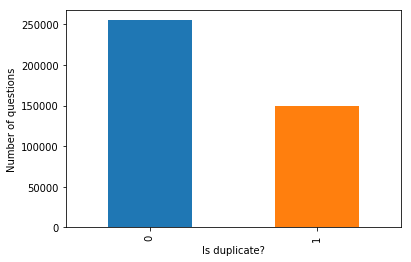

In [5]:
# Graph of is_duplicate v/s number of questions
plt.figure()
plt.xlabel('Is duplicate?')
plt.ylabel('Number of questions')
data['is_duplicate'].value_counts().plot(kind='bar')

In [6]:
# Word count difference between quesion1 and question2
duplicate_pairs = data[data['is_duplicate'] == 1]
non_duplicate_pairs = data[data['is_duplicate']==0]

duplicate_pairs_wordcount_diff = (duplicate_pairs['question1'].str.len() - duplicate_pairs['question2'].str.len()).abs()
non_duplicate_pairs_wordcount_diff = (non_duplicate_pairs['question1'].str.len() - non_duplicate_pairs['question2'].str.len()).abs()

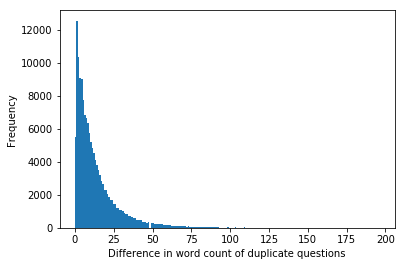

In [7]:
# Graph of difference in word count of duplicate questions v/s number of questions
plt.figure()
plt.xlabel('Difference in word count of duplicate questions')
plt.ylabel('Number of questions')
duplicate_pairs_wordcount_diff.plot(kind='hist', bins=200)

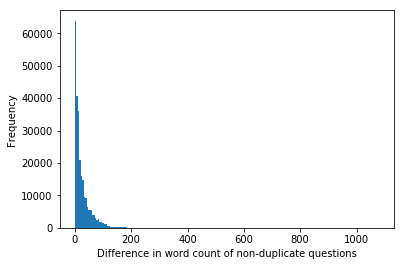

In [8]:
# Graph of difference in word count of non-duplicate questions v/s number of questions
plt.figure()
plt.xlabel('Difference in word count of non-duplicate questions')
plt.ylabel('Number of questions')
non_duplicate_pairs_wordcount_diff.plot(kind='hist', bins=200)

In [9]:
# Jaccard index
def jaccard_index(text1, text2):
    words1 = set(text1.split())
    words2 = set(text2.split())
    
    intersection = len(words1.intersection(words2))
    union = len(words1.union(words2))
    
    return intersection / union

In [10]:
# Return Jaccard similarity for a row
def jaccard_index_for_row(row):
     jaccard_index(str(row['question1']), str(row['question2']))

In [11]:
# Find Jaccard index for duplicate and non-duplicate pairs
duplicate_jaccards = duplicate_pairs.apply(jaccard_index_for_row, axis=1)
#non_duplicate_jaccards = non_duplicate_pairs.apply(jaccard_index_for_row, axis=1)

print (duplicate_pairs.head())
print (duplicate_jaccards.head())
print(duplicate_jaccards.keys)
print ('done')

    id  qid1  qid2                                          question1  \
5    5    11    12  Astrology: I am a Capricorn Sun Cap moon and c...   
7    7    15    16                     How can I be a good geologist?   
11  11    23    24        How do I read and find my YouTube comments?   
12  12    25    26               What can make Physics easy to learn?   
13  13    27    28        What was your first sexual experience like?   

                                            question2  is_duplicate  
5   I'm a triple Capricorn (Sun, Moon and ascendan...             1  
7           What should I do to be a great geologist?             1  
11             How can I see all my Youtube comments?             1  
12            How can you make physics easy to learn?             1  
13             What was your first sexual experience?             1  
5     None
7     None
11    None
12    None
13    None
dtype: object
<bound method Series.keys of 5         None
7         None
11        Non

TypeError: Empty 'DataFrame': no numeric data to plot

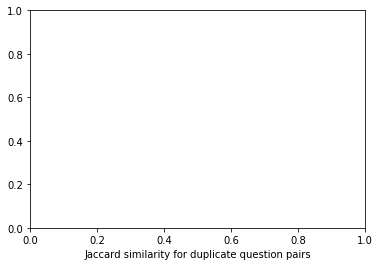

In [12]:
plt.figure()
plt.xlabel('Jaccard similarity for duplicate question pairs')
duplicate_jaccards.plot(kind='hist')

NameError: name 'non_duplicate_jaccards' is not defined

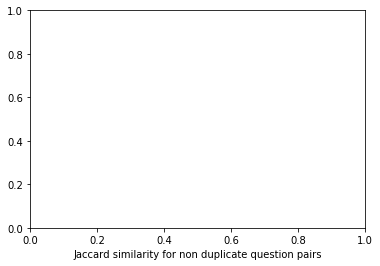

In [13]:
plt.figure()
plt.xlabel('Jaccard similarity for non duplicate question pairs')
non_duplicate_jaccards.plot(kind='hist')

### Benchmark Model

In [14]:
# returns 90% of the dataset as testing data
def get_testing_dataset(data):
    index = int (0.9 * len(data))
    return (pd.DataFrame({'question1':data['question1'][index:,], 'question2':data['question2'][index:,]}),
            data['is_duplicate'][index:,])

In [15]:
benchmark_data = get_testing_dataset(data)

In [16]:
benchmark_data[0].head()

,question1,question2
363861,How do you become both a lawyer and a doctor?,How can you become a lawyer?
363862,How do I get rid of the smell from a cat spray...,How can I stop my cat from spraying?
363863,How does one start a small business?,How can I start a successful small business?
363864,Which are the best GMAT coaching institutes in...,What is the best coaching institute for GMAT i...
363865,What are some good jobs for civil engineer?,Which are the best jobs in civil engineering?


In [17]:
def jaccard_threshold(value):
    if value > 0.5:
        return 1;
    else:
        return 0;

In [20]:
def benchmark_mode_accuracy(benchmark_data):
    data = benchmark_data[0]
    actual = benchmark_data[1]
    predictions = data.apply(jaccard_index_for_row, axis=1).apply(jaccard_threshold)
    
    rights = (predictions == actual).sum()
    wrongs = (predictions != actual).sum()

    accuracy = 1.0 * rights / (rights + wrongs)
    
    return accuracy
    
#print(benchmark_mode_accuracy(benchmark_data))
    
#printst = str(round(100 * benchmark_mode_accuracy(benchmark_data), 2))

print ('Thus, the benchmark model gives an accuracy of',benchmark_mode_accuracy,'%')#

Thus, the benchmark model gives an accuracy of <function benchmark_mode_accuracy at 0x000001AA0638FF28> %


### Feature Extraction

In [21]:
nlp = spacy.load('en')

In [22]:
# Get GloVe vectors for each word
def get_vectors_for_text(nlp, text):
    return np.array([w.vector for w in nlp(text)])

# Take the mean of all the rows, thus getting a single
# row in the end
def mean_pool(text_vectors):
    return np.mean(text_vectors, axis=0)

# Take the max from all rows, thus getting a single
# row in the end
def max_pool(text_vectors):
    return np.max(text_vectors, axis=0)

# Concat of max and mean pool of all vectors
def features_for_text(nlp, text):
    vectors = get_vectors_for_text(nlp, text)
    
    return np.concatenate((max_pool(vectors), mean_pool(vectors)))

In [23]:
get_vectors_for_text(nlp, str(data.loc[0]['question1']))

array([[-2.7591033 ,  1.2157259 , -0.5788861 , ...,  0.5665025 ,
         0.665437  ,  0.13682155],
       [-0.88628864,  1.6891224 , -2.4245555 , ...,  0.02556491,
        -0.04477631,  0.17925572],
       [ 2.142237  ,  0.5824198 ,  0.2973313 , ...,  0.05903636,
         0.2357986 ,  0.43427026],
       ...,
       [ 1.8298793 , -0.41593012,  0.05129522, ...,  0.28585154,
        -0.4082324 ,  0.0481516 ],
       [ 0.17937502,  1.4632998 ,  5.1881733 , ...,  0.20549607,
        -0.25187686, -0.28815144],
       [ 3.6091042 ,  1.0658673 ,  2.6265097 , ..., -0.09160421,
        -0.09837446,  0.02842486]], dtype=float32)

In [24]:
# Helper functions that will be used for stuff like pickling/unpickling data at each checkpoints
directory_name = r'C:\Users\risha\Desktop\Udacity MLND\Capstone\features'

def data_exists(name):
    filename = os.path.join(directory_name, name + '.pickle')
    return os.path.exists(filename)


def save_data(name, content):
    if not os.path.exists(directory_name):
        os.mkdir(directory_name)

    filename = os.path.join(directory_name, name + '.pickle')

    with open(filename, 'wb') as pickle_file:
        pickle.dump(content, pickle_file)


def load_data(name):
    filename = os.path.join(directory_name, name + '.pickle')

    with open(filename, 'rb') as f:
        return pickle.load(f)

In [25]:
print("hi")

hi


In [26]:
def save_vectors(nlp, data):
    if data_exists('vectors'):
        return load_data('vectors')
    features = {
        'question1': [],
        'question2': [],
        'is_duplicate': []
    }

    for i in tqdm(range(len(data))):
        try:
            row = data.loc[i]
            q1 = features_for_text(nlp, str(row['question1']))
            q2 = features_for_text(nlp, str(row['question2']))

            features['question1'].append(q1)
            features['question2'].append(q2)
            features['is_duplicate'].append(row['is_duplicate'])
        except:
            pass
        
    features['question1'] = np.asarray(features['question1'])
    features['question2'] = np.asarray(features['question2'])
    features['is_duplicate'] = np.asarray(features['is_duplicate'])
    
    save_data('vectors', features)
    
    return features

In [27]:
print(nlp(u'hello').vector)

[-1.47970951e+00 -4.21159357e-01  1.06445277e+00 -7.18621016e-02
  2.12101102e+00  1.39717543e+00 -2.16116381e+00  1.11346328e+00
  7.06262708e-01  1.18206561e+00  2.39653420e+00 -1.42033625e+00
  7.76869237e-01 -2.62151432e+00 -2.49098420e+00  1.40702128e+00
 -4.85621989e-01  3.30703914e-01 -1.01403892e+00  2.55613422e+00
  5.65430462e-01  3.04582644e+00  3.22912502e+00 -8.35585356e-01
 -1.43064380e+00 -7.87177622e-01 -1.76928878e-01  2.46902525e-01
  1.35566330e+00 -2.21012235e-02  1.12495148e+00  7.40879178e-01
 -7.66251564e-01  1.47947621e+00 -7.61319697e-01  1.02593589e+00
 -2.20128131e+00  2.84820104e+00 -1.94958520e+00 -3.10584307e-02
  4.57328856e-02  4.47482872e+00  1.55972266e+00  1.20721877e-01
 -3.10773087e+00 -6.38729095e-01 -3.72742534e+00 -2.00596452e-01
  3.07094741e+00 -2.38101482e+00 -1.00460851e+00 -9.03264523e-01
 -6.01313472e-01 -9.85089660e-01 -2.94778883e-01  6.18771613e-01
  3.57110453e+00 -2.22198915e+00 -3.35746932e+00 -8.80977511e-01
 -1.39037907e+00 -2.17773

In [28]:
vectors = save_vectors(nlp, data)

In [29]:
print(len(vectors))

3


### Building the network

Trying multiple networks with different paramters

In [30]:
# Define all combinations
model_params = {
    # Should we use batch normalization or not?
    'batch_norm': [True, False],
    
    # No. of weights in each layer. All layers will have the same
    # weights with ReLU activation
    'no_weights': [100, 200, 300],
    
    # No. of layers
    'no_layers': [2, 4, 6, 8]
}

# Generate all combinations
def generate_combinations(params):
    keys = list(params.keys())
    
    # Generate combinations of current key
    current_key = keys[0]
    current_combinations = []
    for value in params[current_key]:
        d = {}
        d[current_key] = value
        current_combinations.append(d)
        
    # Check if we need recursive processing
    if len(keys) > 1:
        other_combinations = generate_combinations({k:v for k,v in params.items() if k != current_key})
        all_combinations = []
        
        for i in current_combinations:
            for j in other_combinations:
                d = i.copy()
                d.update(j)
                #all_combinations.append(dict(i.items() + j.items()))
                all_combinations.append(dict(d))
                
        return all_combinations
    else:
        return current_combinations
    
all_combinations = generate_combinations(model_params)
print(all_combinations)
print(len(all_combinations))

[{'batch_norm': True, 'no_weights': 100, 'no_layers': 2}, {'batch_norm': True, 'no_weights': 100, 'no_layers': 4}, {'batch_norm': True, 'no_weights': 100, 'no_layers': 6}, {'batch_norm': True, 'no_weights': 100, 'no_layers': 8}, {'batch_norm': True, 'no_weights': 200, 'no_layers': 2}, {'batch_norm': True, 'no_weights': 200, 'no_layers': 4}, {'batch_norm': True, 'no_weights': 200, 'no_layers': 6}, {'batch_norm': True, 'no_weights': 200, 'no_layers': 8}, {'batch_norm': True, 'no_weights': 300, 'no_layers': 2}, {'batch_norm': True, 'no_weights': 300, 'no_layers': 4}, {'batch_norm': True, 'no_weights': 300, 'no_layers': 6}, {'batch_norm': True, 'no_weights': 300, 'no_layers': 8}, {'batch_norm': False, 'no_weights': 100, 'no_layers': 2}, {'batch_norm': False, 'no_weights': 100, 'no_layers': 4}, {'batch_norm': False, 'no_weights': 100, 'no_layers': 6}, {'batch_norm': False, 'no_weights': 100, 'no_layers': 8}, {'batch_norm': False, 'no_weights': 200, 'no_layers': 2}, {'batch_norm': False, 'no

In [31]:
def get_model(params):
    input_1 = Input(shape=(600,), name='question1')
    input_2 = Input(shape=(600,), name='question2')
    layer = keras.layers.concatenate([input_1, input_2])
    
    for i in range(params['no_layers']):
        if params['batch_norm']:
            layer = BatchNormalization()(layer)
        
        layer = Dense(params['no_weights'], activation='relu')(layer)
        
    output = Dense(1, activation='sigmoid')(layer)
    
    model = Model(inputs=[input_1, input_2], outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

### Train the Network

In [32]:
TEST_SPLIT = 0.9
TEST_INDEX = int(TEST_SPLIT * len(vectors['question1']))

print(TEST_INDEX)
print(len(vectors['question1']))

363861
404290


In [33]:
def get_name_from_params(params):
    return "{}_{}_{}.h5".format(str(params['no_weights']), str(params['batch_norm']), str(params['no_layers']))

def train_model(features, params):
    model = get_model(params)
    name = get_name_from_params(params)
    
    if os.path.exists(name):
        print("Already exists: {}".format(name))
        return load_model(name)
    else:
        print("Processing: {}".format(name))
    
    callbacks = [ModelCheckpoint(name, monitor='val_acc', save_best_only=True), CSVLogger(name + '.log')]
    
    question1 = features['question1'][0:TEST_INDEX,]
    question2 = features['question2'][0:TEST_INDEX,]
    is_duplicate = features['is_duplicate'][0:TEST_INDEX,]
    
    model.fit([question1, question2], is_duplicate, epochs=25, validation_split=0.1,
              verbose=True, callbacks=callbacks)
    
    return model

In [34]:
for combination in all_combinations:
    train_model(vectors, combination)

Already exists: 100_True_2.h5


c:\users\risha\anaconda2\envs\py3\lib\site-packages\keras\engine\saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Already exists: 100_True_4.h5
Already exists: 100_True_6.h5
Already exists: 100_True_8.h5
Already exists: 200_True_2.h5
Already exists: 200_True_4.h5
Already exists: 200_True_6.h5
Already exists: 200_True_8.h5
Already exists: 300_True_2.h5
Already exists: 300_True_4.h5
Already exists: 300_True_6.h5
Already exists: 300_True_8.h5
Already exists: 100_False_2.h5
Already exists: 100_False_4.h5
Already exists: 100_False_6.h5
Already exists: 100_False_8.h5
Already exists: 200_False_2.h5
Already exists: 200_False_4.h5
Already exists: 200_False_6.h5
Already exists: 200_False_8.h5
Already exists: 300_False_2.h5
Already exists: 300_False_4.h5
Already exists: 300_False_6.h5
Already exists: 300_False_8.h5


### Test the network

In [35]:
test_scores = {}

t_question1 = vectors['question1'][TEST_INDEX:,]
t_question2 = vectors['question2'][TEST_INDEX:,]
t_is_duplicate = vectors['is_duplicate'][TEST_INDEX:,]

for combination in all_combinations:
    name = get_name_from_params(combination)
    model = train_model(vectors, combination)
    
    test_scores[name] = model.evaluate([t_question1, t_question2], t_is_duplicate)

Already exists: 100_True_2.h5


c:\users\risha\anaconda2\envs\py3\lib\site-packages\keras\engine\saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


ValueError: Error when checking input: expected question1 to have shape (600,) but got array with shape (768,)

In [ ]:
save_data('test', 'scores', test_scores)

In [ ]:
question1.shaoe()